In [1]:
%matplotlib inline
! realpath IKT450
from google.colab import drive
drive.mount('/content/gdrive')
!ls /content/gdrive/MyDrive
! git clone https://github.com/JoarVarpe/IKT450.git
!nvidia-smi

from collections import Counter
import torchvision
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader,Dataset
import matplotlib.pyplot as plt
import torchvision.utils
import numpy as np
import random
import glob
from PIL import Image
import torch
from torch.autograd import Variable
import PIL.ImageOps    
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torchvision

random.seed(7)

/content/IKT450
Mounted at /content/gdrive
 20201124_025526.jpg			     res_50_100+0.pt    res_50_1.pt
 Candito+Linear+Program.pdf		     res_50_100+10.pt   res_50_20.pt
 classifier0.pt				     res_50_100+15.pt   res_50_25.pt
 classifier12.pt			     res_50_100+1.pt    res_50_2.pt
 classifier13.pt			     res_50_100+20.pt   res_50_30.pt
 classifier14.pt			     res_50_100+25.pt   res_50_35.pt
 classifier16.pt			     res_50_100+30.pt   res_50_38.pt
 classifier1.pt				     res_50_100+35.pt   res_50_39.pt
 classifier2.pt				     res_50_100+40.pt   res_50_3.pt
 classifier3.pt				     res_50_100+45.pt   res_50_40.pt
 classifier4.pt				     res_50_100+50.pt   res_50_45.pt
 classifier5.pt				     res_50_100+55.pt   res_50_48.pt
 classifier6.pt				     res_50_100+5.pt    res_50_49.pt
 classifier7.pt				     res_50_100+60.pt   res_50_50.pt
 classifier_body0.pt			     res_50_100+65.pt   res_50_55.pt
 classifier_body11.pt			     res_50_100+70.pt   res_50_5.pt
 classifier_body1.pt			     res_50_100+75.

In [2]:
def imshow(img,text=None,should_save=False):
    npimg = img.numpy()
    plt.axis("off")
    if text:
        plt.text(75, 8, text, style='italic',fontweight='bold',
            bbox={'facecolor':'white', 'alpha':0.8, 'pad':10})
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()    

def show_plot(iteration,loss):
    plt.plot(iteration,loss)
    plt.show()

In [3]:
class Config():
    training_dir = "/content/IKT450/0_8/train/"
    testing_dir = "/content/IKT450/0_8/test/"
    training_dir_body = "/content/IKT450/0_8_body/train/"
    testing_dir_body = "/content/IKT450/0_8_body/test/"
    train_batch_size = 64
    train_number_epochs = 100

In [8]:
class SiameseNetworkDataset(Dataset):
    
    def __init__(self,imageFolderDataset, percent_same=None, transform=None):
        self.imageFolderDataset = imageFolderDataset    
        self.transform = transform
        self.percent_same = percent_same
        print(self.percent_same)
        
        
    def __getitem__(self,index):
        img0_tuple = self.imageFolderDataset.imgs[index]
        #we need to make sure approx 50% of images are in the same class
        if self.percent_same != None:
          should_get_same_class = self.percent_same
        else:
          
          should_get_same_class = random.randint(0,1) 

        if should_get_same_class:
            while True:
                #keep looping till the same class image is found
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1]==img1_tuple[1]:
                    break
        else:
            while True:
                #keep looping till a different class image is found
                
                img1_tuple = random.choice(self.imageFolderDataset.imgs) 
                if img0_tuple[1] !=img1_tuple[1]:
                    break

        img0 = Image.open(img0_tuple[0])
        img1 = Image.open(img1_tuple[0])
        img0 = img0.convert("L")
        img1 = img1.convert("L")
        

        if self.transform is not None:
            img0 = self.transform(img0)
            img1 = self.transform(img1)
        
        return img0, img1 , torch.from_numpy(np.array([int(img1_tuple[1]!=img0_tuple[1])],dtype=np.float32))
    
    def __len__(self):
        return len(self.imageFolderDataset.imgs)

In [9]:
folder_dataset = dset.ImageFolder(root=Config.training_dir)
folder_dataset_body = dset.ImageFolder(root=Config.training_dir_body)

In [10]:
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

siamese_dataset_body= SiameseNetworkDataset(imageFolderDataset=folder_dataset_body,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       )

None
None


In [11]:
class SiameseNetwork(nn.Module):
    #from https://hackernoon.com/facial-similarity-with-siamese-networks-in-pytorch-9642aa9db2f7
    #Output size after convolution
    #w = initial img size, k = kernel size, s = stride, p = padding
    #((w - k + 2P)/s) + 1
    
    #input here is 100 px x 100 px 
    
    def __init__(self):
        super(SiameseNetwork, self).__init__()
        self.res_net = torch.hub.load('pytorch/vision:v0.6.0', 'resnet50', pretrained=True)
        self.fc1 = nn.Linear(1000, 128)
        self.cnn1 = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(1, 4, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(4),
            
            nn.ReflectionPad2d(1),
            nn.Conv2d(4, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


            nn.ReflectionPad2d(1),
            nn.Conv2d(8, 8, kernel_size=3),
            nn.ReLU(inplace=True),
            nn.BatchNorm2d(8),


        )

        self.fc1 = nn.Sequential(
            nn.Linear(8*100*100, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 500),
            nn.ReLU(inplace=True),

            nn.Linear(500, 5))

    def forward_once(self, x):
        output = self.res_net(x)
        output = output.view(output.size()[0], -1)
        output = self.fc1(output)
        return output

    def forward(self, input1, input2):
        output1 = self.forward_once(input1)
        output2 = self.forward_once(input2)
        return output1, output2

In [12]:
class ContrastiveLoss(torch.nn.Module):
    """
    Contrastive loss function.
    Based on: http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    """

    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        euclidean_distance = F.pairwise_distance(output1, output2, keepdim = True)
        # d = euclidean_distance.detach().numpy()
        # if (d < 0).sum() > 0:
          # print("Got euclidean distance: ", d)
        loss_contrastive = torch.mean((1-label) * torch.pow(euclidean_distance, 2) +
                                      (label) * torch.pow(torch.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

In [13]:
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

preprocess = transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])

folder_dataset_body_test = dset.ImageFolder(root=Config.testing_dir_body)
siamese_dataset_body_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_body_test,
                                        transform=preprocess)

train_dataloader_body = DataLoader(siamese_dataset_body,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

test_dataloader_body = DataLoader(siamese_dataset_body_test,
                        shuffle=False,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

train_count_body = len(glob.glob(Config.training_dir_body + "/**/*.jpg"))
test_count_body = len(glob.glob(Config.testing_dir_body + "/**/*.jpg"))
print(train_count_body, test_count_body)

folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
siamese_dataset_test = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        transform=preprocess)

train_dataloader = DataLoader(siamese_dataset,
                        shuffle=True,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

test_dataloader = DataLoader(siamese_dataset_test,
                        shuffle=False,
                        num_workers=8,
                        batch_size=Config.train_batch_size)

train_count = len(glob.glob(Config.training_dir + "/**/*.jpg"))
test_count = len(glob.glob(Config.testing_dir + "/**/*.jpg"))
print(train_count, test_count)



None
1687 426
None
1690 423


In [14]:
counter = []
loss_history = [] 
iteration_number= 0
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
best_loss = 1e10
for epoch in range(0,Config.train_number_epochs):
    
    total_train = 0
    correct_train = 0
    loss = 1.0
    net.train()
    for i, data in enumerate(train_dataloader,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        loss = loss_contrastive.item()
        
        #accuracy

    net.eval()
    total_loss = 0
    for i, data in enumerate(test_dataloader,0):
        with torch.no_grad():
          img0, img1 , label = data
          img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
          optimizer.zero_grad()
          output1,output2 = net(img0,img1)
          loss_contrastive = criterion(output1,output2,label)
          total_loss += loss_contrastive.item()
        #print

    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
    print("Current Accuracy: Not Implemented, find thresh first")
    iteration_number +=1
    counter.append(iteration_number)
    loss_history.append(loss_contrastive.item())

    # if total_loss < best_loss:
    #   print("saving model :)))))")
    #   best_loss = total_loss
    #   model_save_name = 'classifier{}.pt'.format(epoch)
    #   path = F"/content/gdrive/MyDrive/{model_save_name}" 
    #   torch.save(net.state_dict(), path)
    #   print("Save is done Ok Ok Ok.")
    #   print("Total_loss: ", total_loss)
    # else:
    #   print("Loss {} is not better than best loss {}".format(total_loss, best_loss))


show_plot(counter,loss_history)

Downloading: "https://github.com/pytorch/vision/archive/v0.6.0.zip" to /root/.cache/torch/hub/v0.6.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


RuntimeError: ignored

Epoch number 0
 Current loss 1.211300253868103

Current Accuracy: Not Implemented, find thresh first
saving model :)))))
Save is done Ok Ok Ok.
Total_loss:  7.358695030212402
Epoch number 1
 Current loss 1.1253553628921509

Current Accuracy: Not Implemented, find thresh first
saving model :)))))
Save is done Ok Ok Ok.
Total_loss:  6.767774760723114
Epoch number 2
 Current loss 0.6040231585502625

Current Accuracy: Not Implemented, find thresh first
saving model :)))))
Save is done Ok Ok Ok.
Total_loss:  5.469441056251526
Epoch number 3
 Current loss 0.8224618434906006

Current Accuracy: Not Implemented, find thresh first
saving model :)))))
Save is done Ok Ok Ok.
Total_loss:  5.329757750034332
Epoch number 4
 Current loss 0.7855862379074097

Current Accuracy: Not Implemented, find thresh first
Loss 5.5618703961372375 is not better than best loss 5.329757750034332
Epoch number 5
 Current loss 0.7384808659553528

Current Accuracy: Not Implemented, find thresh first
saving model :)))))
Sa

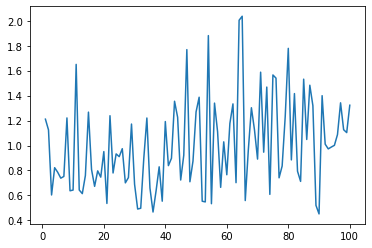

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0
net = SiameseNetwork().cuda()
criterion = ContrastiveLoss()
optimizer = optim.Adam(net.parameters(),lr = 0.0005 )
best_loss = 1e10
for epoch in range(0,Config.train_number_epochs):
    
    total_train = 0
    correct_train = 0
    loss = 1.0
    net.train()
    for i, data in enumerate(train_dataloader_body,0):
        img0, img1 , label = data
        img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
        optimizer.zero_grad()
        output1,output2 = net(img0,img1)
        loss_contrastive = criterion(output1,output2,label)
        loss_contrastive.backward()
        optimizer.step()

        loss = loss_contrastive.item()
        
        #accuracy

    net.eval()
    total_loss = 0
    for i, data in enumerate(test_dataloader_body,0):
        with torch.no_grad():
          img0, img1 , label = data
          img0, img1 , label = img0.cuda(), img1.cuda() , label.cuda()
          optimizer.zero_grad()
          output1,output2 = net(img0,img1)
          loss_contrastive = criterion(output1,output2,label)
          total_loss += loss_contrastive.item()
        #print

    print("Epoch number {}\n Current loss {}\n".format(epoch,loss_contrastive.item()))
    print("Current Accuracy: Not Implemented, find thresh first")
    iteration_number +=1
    counter.append(iteration_number)
    loss_history.append(loss_contrastive.item())

    if total_loss < best_loss:
      print("saving model :)))))")
      best_loss = total_loss
      model_save_name = 'classifier_body{}.pt'.format(epoch)
      path = F"/content/gdrive/MyDrive/{model_save_name}" 
      torch.save(net.state_dict(), path)
      print("Save is done Ok Ok Ok.")
      print("Total_loss: ", total_loss)
    else:
      print("Loss {} is not better than best loss {}".format(total_loss, best_loss))


show_plot(counter,loss_history)

In [ ]:
net = SiameseNetwork().cuda()
model_save_name = 'classifier3.pt'
# model_save_name = 'classifier_body11.pt'
path = F"/content/gdrive/My Drive/{model_save_name}"
net.load_state_dict(torch.load(path))
net.eval()

SiameseNetwork(
  (cnn1): Sequential(
    (0): ReflectionPad2d((1, 1, 1, 1))
    (1): Conv2d(1, 4, kernel_size=(3, 3), stride=(1, 1))
    (2): ReLU(inplace=True)
    (3): BatchNorm2d(4, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): ReflectionPad2d((1, 1, 1, 1))
    (5): Conv2d(4, 8, kernel_size=(3, 3), stride=(1, 1))
    (6): ReLU(inplace=True)
    (7): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReflectionPad2d((1, 1, 1, 1))
    (9): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1))
    (10): ReLU(inplace=True)
    (11): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc1): Sequential(
    (0): Linear(in_features=80000, out_features=500, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU(inplace=True)
    (4): Linear(in_features=500, out_features=5, bias=True)
  )
)

NameError: ignored

In [ ]:
#@title
folder_dataset_test = dset.ImageFolder(root=Config.testing_dir)
folder_dataset_test = dset.ImageFolder(root=Config.training_dir)
siamese_dataset = SiameseNetworkDataset(imageFolderDataset=folder_dataset_test,
                                        # percent_same=0.25,
                                        transform=transforms.Compose([transforms.Resize((100,100)),
                                                                      transforms.ToTensor()
                                                                      ])
                                       ,should_invert=False)
best_thresh = None
best_accuracy = -1


for test_it in range(30):
    counter = Counter()
    threshold = (test_it + 1) * 0.1
    test_dataloader = DataLoader(siamese_dataset,num_workers=6,batch_size=1,shuffle=False)
    dataiter1 = iter(test_dataloader)

    correct = 0
    wrong = 0
    max_distance = 0
    min_distance = 55
    for i in range(len(dataiter1)):
        x0,x1,label = next(dataiter1)
        
        with torch.no_grad():
            output1,output2 = net(Variable(x0).cuda(),Variable(x1).cuda())
        euclidean_distance = F.pairwise_distance(output1, output2)

        the_distance = euclidean_distance.item()

        if the_distance > max_distance:
            max_distance = the_distance
        if the_distance < min_distance:
            min_distance = the_distance

        if the_distance > threshold:
            same = 0
        else:
            same = 1

        if same == 0 and label.item() == 0:
          counter["TN"] += 1
        elif same == 0 and label.item() == 1:
          counter["FN"] += 1
        elif same == 1 and label.item() == 0:
          counter["FP"] += 1
        else:
          counter["TP"] += 1

        if same == label.item():
            correct += 1
        else:
            wrong += 1
    acc = correct / (correct + wrong)
    print("Th: {:.2f}  Accuracy: {:.4f}".format(threshold, acc))
    print(counter)
    if acc > best_accuracy:
        print("\tnew best acc!!!!")
        best_accuracy = acc
        best_thresh = threshold
        
        
          

print("the best threshold is:", best_thresh, "with accuracy: ", best_accuracy)


None
Th: 0.10  Accuracy: 0.3834
Counter({'FN': 838, 'TN': 648, 'FP': 204})
	new best acc!!!!
Th: 0.20  Accuracy: 0.4012
Counter({'FN': 815, 'TN': 677, 'FP': 197, 'TP': 1})
	new best acc!!!!
Th: 0.30  Accuracy: 0.3846
Counter({'FN': 833, 'TN': 645, 'FP': 207, 'TP': 5})
Th: 0.40  Accuracy: 0.3527
Counter({'FN': 868, 'TN': 589, 'FP': 226, 'TP': 7})
Th: 0.50  Accuracy: 0.3562
Counter({'FN': 855, 'TN': 578, 'FP': 233, 'TP': 24})
Th: 0.60  Accuracy: 0.3716
Counter({'FN': 799, 'TN': 587, 'FP': 263, 'TP': 41})
Th: 0.70  Accuracy: 0.3805
Counter({'FN': 750, 'TN': 544, 'FP': 297, 'TP': 99})
Th: 0.80  Accuracy: 0.3509
Counter({'FN': 760, 'TN': 462, 'FP': 337, 'TP': 131})
Th: 0.90  Accuracy: 0.3680
Counter({'FN': 697, 'TN': 445, 'FP': 371, 'TP': 177})
Th: 1.00  Accuracy: 0.3627
Counter({'FN': 651, 'FP': 426, 'TN': 393, 'TP': 220})
